### libraries

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.pyplot as plt

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



### Data collection
![figure](data_collection.PNG)

#### Steps in data collection
1. load the whole dataset
2. vectorize the news category with [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
3. split the data into 80% training set, 10% test set and 10% validation set <br />
   we use function **train_test_split** to split 80% training set and 20% test set firstly, then use the function again to split test set into 10% test set and 10% validation set

#### Note
Because we are going to use random forest, we don't need to perform standardization on the features

In [2]:
# load the whole dataset
newsgroups = fetch_20newsgroups(subset='all')

# vectorize the dataset with TF-IDF
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

# split the original dataset into 20% validation set, 10% test set and 80% training set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# split the test set into 50% validation set and 50% test set (both are 10% of the original dataset)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)


### Model selection

![model selection](model_selection.png)


#### Random forest
As required, we select random forest and use grid search to find the best parameters for 
- n_estimators : number of decision trees
- max_depth &nbsp; &nbsp;: depth of each tree

We constrain our max_depth upto 30 and n_estimator upto 1000, and we also test on several setting in other arguments such as min_samples_leaf and max_features, but we find that the default setting has the best performance:

| argument         | range              |
|------------------|--------------------|
| n_estimator      | 100 - 1000      |
| max_depth        | 10, 15, 20 ,25, 30 |
| max_features     | default: "sqrt"    |
| min_samples_leaf | default: 1         |


#### Evaluation metric
We use the function [f1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) to evaluate the performance of classifier because it considers both metrics **accuracy** and **recall**. 


#### Note
In this part we don't use cross validation during grid search. Based on the requirement of 80% training set and 10% test set, we need to perform 9-fold cross-validation and it would take a huge amount of time when n_estimators and max_depth are large. Our concern is the execution time, so we use same validation set and training set to evaluate the metric. Overfitting can actually be avoided by increasing n_estimators, and therefore cross validation is not really necessary here.



In [3]:
# variables to store the best parameters and model
accuracy = best_accuracy = best_n_estimators = best_max_depth = 0

n1 = 10
n2 = 3

n_estimators_arr = [i*100 + 100 for i in range(n1)]
max_depth_arr = [i*10 + 10 for i in range(n2)]
accuracy_test_array = np.zeros([n1,n2])
accuracy_train_array = np.zeros([n1,n2])

# grid search the best parameters
for i, n_estimators in enumerate(n_estimators_arr):
    for j, max_depth in enumerate(max_depth_arr):

        # build the model and train
        clf = RandomForestClassifier(n_estimators=n_estimators, 
                                     max_depth=max_depth,
                                     n_jobs=4)
        clf.fit(x_train, y_train)

        # test the performance with validation set
        # 'macro' means calculating metrics for each label, and finding their unweighted mean
        accuracy = accuracy_test_array[i,j] = f1_score(y_val, clf.predict(x_val), average = 'macro')
        accuracy_train_array[i,j] = f1_score(y_train, clf.predict(x_train), average = 'macro')
        
        # record the best one
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_estimators = n_estimators 
            best_max_depth = max_depth
            best_model = clf
            
print('best n_estimators            :', n_estimators)
print('best max_depth               :', max_depth)
print('best validation accuracy     :', best_accuracy)
print('test accuracy                :', f1_score(y_test, best_model.predict(x_test), average = 'macro'))


best n_estimators            : 1000
best max_depth               : 30
best validation accuracy     : 0.822394243572
test accuracy                : 0.817368666026


#### Learning curve

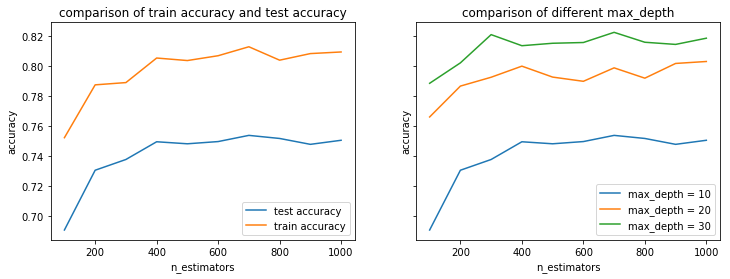

In [4]:
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)
f.set_figwidth(12)
ax1.plot(n_estimators_arr, accuracy_test_array[:,0], label = 'test accuracy')
ax1.plot(n_estimators_arr, accuracy_train_array[:,0], label = 'train accuracy')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('accuracy')
ax1.set_title('comparison of train accuracy and test accuracy')
ax1.legend()

ax2.plot(n_estimators_arr, accuracy_test_array[:,0], label = 'max_depth = 10')
ax2.plot(n_estimators_arr, accuracy_test_array[:,1], label = 'max_depth = 20')
ax2.plot(n_estimators_arr, accuracy_test_array[:,2], label = 'max_depth = 30')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('accuracy')
ax2.set_title('comparison of different max_depth')
ax2.legend()

plt.show()

#### Confusion matrix

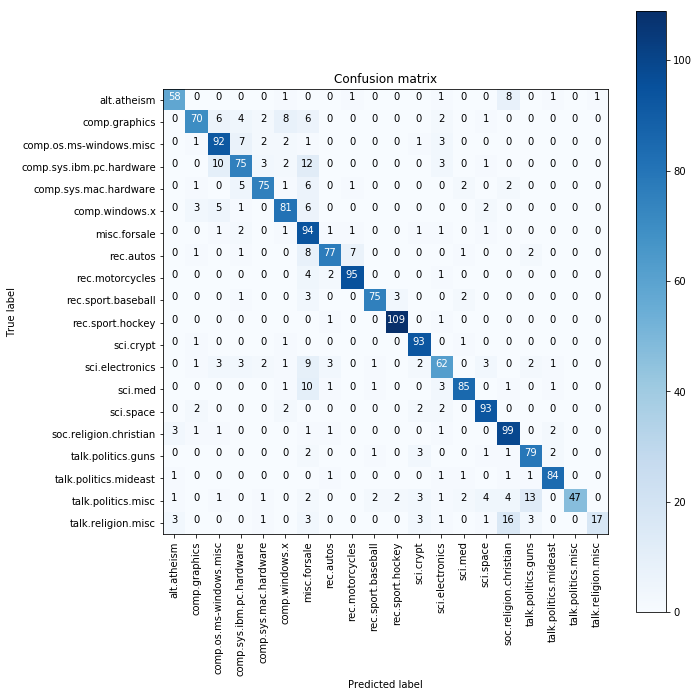

In [5]:
# create confusion matrix
cnf_matrix = confusion_matrix(y_test, best_model.predict(x_test))
# np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot the confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names,
                      title='Confusion matrix')
plt.show()

### Model assessment

![model assessment](model_assessment.png)

#### Cross-validation
To assess our model best n_estimator and max_depth from grid search, we perform 10-fold cross validation on our best model. Note that this time we feed all the data to perform 10-fold cross validation

In [6]:
def build_k_indices(y, k_fold):
    """Function to build k indices for k-fold.

    Args:
        y      (numpy array): Matrix output of size N x 1.
        k_fold (int)        : The value k, of k-fold cross validation.
        seed   (int)        : Integer value to seed the random generator.

    Returns:
        k_indices (numpy array) : Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
    """
    seed = 1
    num_row    = y.shape[0]
    interval   = int(num_row / k_fold)
    np.random.seed(seed)
    indices    = np.random.permutation(num_row)
    k_indices  = np.array([indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)])
    return k_indices

def data_split(y, x, k_indices, k):
    """Function to split training data and test data using K-cross validation based on given k_indices.

    Args:
        y         (numpy array): Matrix output of size N x 1.
        tx        (numpy array): Matrix input of size N x D.
        k_indices (numpy array): Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
        k         (int)        : For choosing index in the k_indices

    Returns:
        x_train (numpy array) : Matrix input (features) for training set with size of (ratio*N) x D.
        y_train (numpy array) : Matrix output for training set with size of (ratio*N) x 1.
        x_test  (numpy array) : Matrix input (features) for testing set with size of ((1-ratio)*N) x D.
        y_test  (numpy array) : Matrix output for testing set with size of ((1-ratio)*N) x 1.
    """
    
    train_set_indices               = np.ones(x.shape[0], dtype = bool)
    train_set_indices[k_indices[k]] = False

    x_train = x[train_set_indices]
    y_train = y[train_set_indices]
    
    x_test  = x[k_indices[k]]
    y_test  = y[k_indices[k]]
    
    return x_train, y_train, x_test, y_test



# build validation set
k_fold = 10
k_indices = build_k_indices(newsgroups.target, k_fold)

# best classifier from grid search
clf = RandomForestClassifier(n_estimators=best_n_estimators, 
                             max_depth=best_max_depth,
                             n_jobs=4)

accuracy_arr = np.zeros(k_fold)

# perform 10-fold cross validation
for k in range(k_fold):
    x_train, y_train, x_test, y_test = data_split(y = y, x = x, k_indices=k_indices, k=k)
    clf.fit(x_train, y_train)
    accuracy_arr[k] = f1_score(y_test, clf.predict(x_test), average = 'macro')
    
print('average f1 score = ', np.mean(accuracy))

average f1 score =  0.81848924789


In [7]:
clf.feature_importances_[clf.feature_importances_ != 0]

array([  2.37884918e-04,   1.77211031e-04,   2.48254286e-06, ...,
         5.65712048e-07,   5.88933396e-07,   2.63004911e-06])